In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

RND = 42
np.random.seed(RND)


In [3]:
#Load CSVs (train + test) and parse times
train_path = r"F:\Projects\neural_symbolic\neural_symbolic\data\train_data.csv"
test_path  = r"F:\Projects\neural_symbolic\neural_symbolic\data\test_data.csv"

train = pd.read_csv(train_path, low_memory=False)
test  = pd.read_csv(test_path, low_memory=False)

# parse start_time and account_creation_date if available
for df in (train, test):
    if 'start_time' in df.columns:
        df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    if 'account_creation_date' in df.columns:
        df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')


C:\Users\Dell\AppData\Local\Temp\ipykernel_14164\1569026135.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')
C:\Users\Dell\AppData\Local\Temp\ipykernel_14164\1569026135.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')


In [5]:
#2) Robustly turn correct into numeric correct_binary
#correct in your CSV may be True/False, 1/0, or missing — make it numeric 0/1.
def make_correct_binary(s):
    s = s.copy()
    # try numeric conversion
    num = pd.to_numeric(s, errors='coerce')
    mapped = s.map({'True':1, 'False':0, 'true':1, 'false':0, True:1, False:0})
    out = num.fillna(mapped)
    out = out.fillna(0).astype(int)   # missing -> 0 (you can change fill strategy)
    return out

train['correct_binary'] = make_correct_binary(train.get('correct', pd.Series(0)))
test['correct_binary']  = make_correct_binary(test.get('correct', pd.Series(0)))


In [6]:
#3) Feature engineering: add lag / rolling features per student

#These capture short-term history that the LSTM learned from sequences (rolling accuracy, streaks, time since last interaction, etc.).

def add_history_features(df, id_col='student_id', time_col='start_time', windows=[3,5,12]):
    df = df.sort_values([id_col, time_col]).copy()
    # interaction index per student
    df['interaction_count'] = df.groupby(id_col).cumcount()
    # time since last interaction (seconds)
    if time_col in df.columns:
        df['time_since_last'] = df.groupby(id_col)[time_col].diff().dt.total_seconds().fillna(0)
    else:
        df['time_since_last'] = 0.0

    # previous correct (binary) and rolling means (shifted so they use past only)
    df['prev_correct'] = df.groupby(id_col)['correct_binary'].shift(1).fillna(0).astype(int)

    for w in windows:
        df[f'rolling_correct_mean_{w}'] = (
            df.groupby(id_col)['correct_binary']
              .apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
              .reset_index(level=0, drop=True)
              .fillna(0)
        )
        # rolling mean of time_on_task (if it exists)
        if 'time_on_task' in df.columns:
            df[f'rolling_time_on_task_mean_{w}'] = (
                df.groupby(id_col)['time_on_task']
                  .apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
                  .reset_index(level=0, drop=True)
                  .fillna(0)
            )
        else:
            df[f'rolling_time_on_task_mean_{w}'] = 0.0

    # previous correct streak length (consecutive previous corrects)
    def streak_prev_correct(series):
        prev = series.shift(1).fillna(0).astype(int).values
        streak = np.zeros_like(prev, dtype=int)
        cur = 0
        for i, v in enumerate(prev):
            if v == 1:
                cur += 1
            else:
                cur = 0
            streak[i] = cur
        return streak

    df['prev_correct_streak'] = df.groupby(id_col)['correct_binary'].apply(lambda x: pd.Series(streak_prev_correct(x), index=x.index)).reset_index(level=0, drop=True)
    return df

# Apply to both datasets
train = add_history_features(train)
test  = add_history_features(test)


In [8]:
#4) Choose features to feed XGBoost
# base numeric candidates that exist in your CSV
num_candidates = [
    'time_on_task', 'fraction_of_hints_used', 'attempt_count',
    'student_answer_count', 'mean_correct', 'mean_time_on_task',
    'started_problem_sets_count', 'completed_problem_sets_count',
    'started_skill_builders_count', 'mastered_skill_builders_count',
    'answered_problems_count', 'mean_problem_correctness',
    'mean_problem_time_on_task', 'mean_class_score',
    'correct_binary', 'interaction_count', 'time_since_last',
    'prev_correct', 'prev_correct_streak'
]
# add rolling windows we created
num_candidates += [c for c in train.columns if c.startswith('rolling_correct_mean_') or c.startswith('rolling_time_on_task_mean_')]

# categorical candidates (strings / small-cardinality)
cat_candidates = [
    'answer_before_tutoring', 'answer_given', 'problem_completed',
    'content_source', 'skills', 'problem_type', 'tutoring_types'
]
# keep only columns that exist
numerical_features = [c for c in num_candidates if c in train.columns]
categorical_features = [c for c in cat_candidates if c in train.columns]

print("Numerical features used:", numerical_features)
print("Categorical features used:", categorical_features)


Numerical features used: ['time_on_task', 'fraction_of_hints_used', 'attempt_count', 'student_answer_count', 'mean_correct', 'mean_time_on_task', 'started_problem_sets_count', 'completed_problem_sets_count', 'started_skill_builders_count', 'mastered_skill_builders_count', 'answered_problems_count', 'mean_problem_correctness', 'mean_problem_time_on_task', 'mean_class_score', 'correct_binary', 'interaction_count', 'time_since_last', 'prev_correct', 'prev_correct_streak', 'rolling_correct_mean_3', 'rolling_time_on_task_mean_3', 'rolling_correct_mean_5', 'rolling_time_on_task_mean_5', 'rolling_correct_mean_12', 'rolling_time_on_task_mean_12']
Categorical features used: ['answer_before_tutoring', 'answer_given', 'problem_completed', 'content_source', 'skills', 'problem_type', 'tutoring_types']


In [9]:
#5) Encode categorical features (LabelEncoder) — fit on combined train+test for consistency
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    combined = pd.concat([
        train[col].fillna('Missing').astype(str),
        test[col].fillna('Missing').astype(str)
    ], axis=0)
    le.fit(combined)
    train[f'{col}_enc'] = le.transform(train[col].fillna('Missing').astype(str))
    test[f'{col}_enc']  = le.transform(test[col].fillna('Missing').astype(str))
    label_encoders[col] = le

encoded_cat_features = [f'{c}_enc' for c in categorical_features]


In [10]:
feature_columns = numerical_features + encoded_cat_features
# remove duplicates and ensure existence
feature_columns = [c for i, c in enumerate(feature_columns) if c in train.columns and feature_columns.index(c) == i]
print("Final feature count:", len(feature_columns))


Final feature count: 32


In [11]:
# target
target = 'next_correct'
if train[target].dtype == 'bool':
    y_full = train[target].astype(int)
else:
    y_full = train[target].astype(int)

X_full = train[feature_columns].fillna(0)   # tree model ok with scaling, but fillna good

# Group split so same student not in both sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RND)
train_idx, val_idx = next(gss.split(X_full, y_full, groups=train['student_id']))
X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

print("Train rows:", len(X_train), "Val rows:", len(X_val))


Train rows: 88478 Val rows: 21996


In [16]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',
    random_state=RND
)

xgb_model.fit(X_train, y_train)  # no eval_set, no early_stopping_rounds


f:\Projects\neural_symbolic\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [17]:
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred  = (y_val_proba > 0.5).astype(int)

acc   = accuracy_score(y_val, y_val_pred)
prec  = precision_score(y_val, y_val_pred, zero_division=0)
rec   = recall_score(y_val, y_val_pred, zero_division=0)
f1    = f1_score(y_val, y_val_pred, zero_division=0)
auc   = roc_auc_score(y_val, y_val_proba)
cm    = confusion_matrix(y_val, y_val_pred)

print("Validation results:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_val, y_val_pred, digits=4))


Validation results:
Accuracy: 0.7616, Precision: 0.7780, Recall: 0.8494, F1: 0.8121, AUC: 0.8377
Confusion matrix:
 [[ 5420  3234]
 [ 2009 11333]]

Classification report:
               precision    recall  f1-score   support

           0     0.7296    0.6263    0.6740      8654
           1     0.7780    0.8494    0.8121     13342

    accuracy                         0.7616     21996
   macro avg     0.7538    0.7379    0.7431     21996
weighted avg     0.7589    0.7616    0.7578     21996



<Figure size 800x600 with 0 Axes>

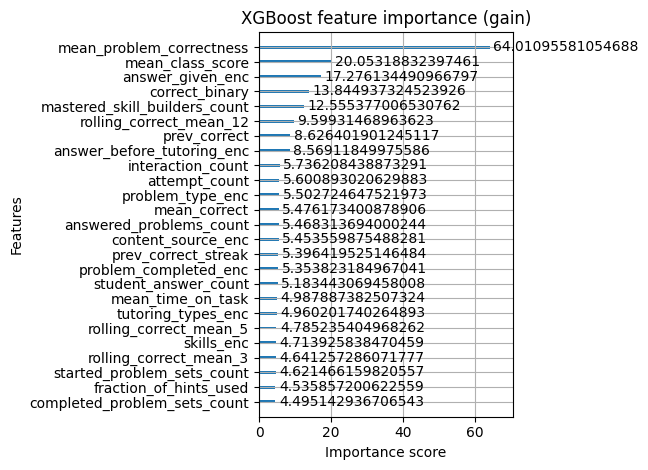

Saved model and artifacts.


In [18]:
# feature importance (top 25)
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_model, max_num_features=25, importance_type='gain')
plt.title('XGBoost feature importance (gain)')
plt.tight_layout()
plt.show()

# Save model and label encoders for inference
joblib.dump(xgb_model, "xgb_next_correct_model.joblib")
joblib.dump(feature_columns, "xgb_feature_columns.joblib")
joblib.dump(label_encoders, "xgb_label_encoders.joblib")
print("Saved model and artifacts.")


In [19]:
def predict_next_with_xgb(model, df, label_encoders, feature_columns, id_col='student_id', time_col='start_time'):
    df = df.copy()
    # ensure times are datetime
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    # create history features same as training
    df = add_history_features(df, id_col=id_col, time_col=time_col, windows=[3,5,12])
    # convert correct into binary if necessary
    df['correct_binary'] = make_correct_binary(df.get('correct', pd.Series(0)))

    # encode categoricals using stored encoders (unknown -> 'Missing' handled)
    for col, le in label_encoders.items():
        col_enc = f"{col}_enc"
        df[col] = df[col].fillna('Missing').astype(str)
        # map unknown values to 'Missing' label if required
        # (if 'Missing' wasn't in encoder classes, label_encoder will raise; we fit encoders earlier with 'Missing')
        df[col_enc] = df[col].map(lambda x: x if x in le.classes_ else 'Missing')
        df[col_enc] = le.transform(df[col_enc])

    # create X
    X = df[feature_columns].fillna(0)
    proba = model.predict_proba(X)[:, 1]
    pred = (proba > 0.5).astype(int)
    df['pred_proba'] = proba
    df['pred_next_correct'] = pred
    return df


In [20]:
# Example: predict on the test set rows (this will compute features using test history)
test_with_preds = predict_next_with_xgb(xgb_model, test, label_encoders, feature_columns)
print(test_with_preds[['student_id','start_time','pred_proba','pred_next_correct']].head())


   student_id                       start_time  pred_proba  pred_next_correct
0        3254 2021-05-12 22:04:52.975000+00:00    0.765161                  1
1        3254 2021-05-12 22:10:56.760000+00:00    0.746616                  1
2        3254 2021-05-20 19:42:06.873000+00:00    0.777728                  1
3        3254 2021-05-20 19:44:09.808000+00:00    0.767181                  1
4        3254 2021-05-21 19:24:22.986000+00:00    0.739109                  1
